In [49]:
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import re
import requests
import zipfile as zpf
from tqdm import tqdm
from PIL import Image
from ADMS_functions import extract_dataset_time_axis, plot_timeseries, PointXYZ_to_latlon, plot_on_map, plot_in_grid_box, process_timeseries_dataset

In [3]:
run = "015"
folder = f"/home/users/mwlw3/ADMS-Urban/2019_hourly_met/all_regions/{run}/"
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]
processed_coordinates_filepath = path.join(folder, "raw_processed_coordinates.nc")

In [12]:
# Processing from raw ADMS-Urban outputs to a netCDF file with useful attributes and latitude/longitude coordinates
# One region at a time
processed_regions_folder = path.join(folder, "raw_processed_regions")
if not path.exists(processed_regions_folder):
    makedirs(processed_regions_folder)
print("Checking region files...")
for i in tqdm(range(len(files))):
    region = files[i].split(".")[-2]
    region_filepath = path.join(folder, "raw_processed_regions", f"{region}.nc")
    print(region_filepath)
    if not path.exists(region_filepath):
        region_ds = process_timeseries_dataset(xr.open_dataset(files[i]))
        region_ds.to_netcdf(region_filepath)
print("Removing raw files.")
[remove(file) for file in files]
print("Done.")

0it [00:00, ?it/s]

Checking region files...
Removing raw files.
Done.


In [61]:
files = [path.join(processed_regions_folder, file) for file in listdir(processed_regions_folder)]

monthly_regions = []

month_i = 1

for files_i in tqdm(range(len(files))):
    ds = xr.open_dataset(files[files_i])
    year = int(re.findall("\d\d\d\d", folder)[0])
    ds = ds.isel(time=(ds.datetime.dt.year==year))
    ds = ds.isel(time=(ds.datetime.dt.month==month_i))
    monthly_regions.append(ds)

100%|██████████| 359/359 [00:10<00:00, 34.08it/s]


In [64]:
monthly_ds = xr.concat(monthly_regions, dim="space")

In [90]:
new_gdf = gpd.GeoDataFrame(monthly_ds.mean(dim="time")["NO2"].values, 
                 columns=["2019_month_mean_NO2"], 
                 geometry=gpd.points_from_xy(monthly_ds.longitude.values, monthly_ds.latitude.values))

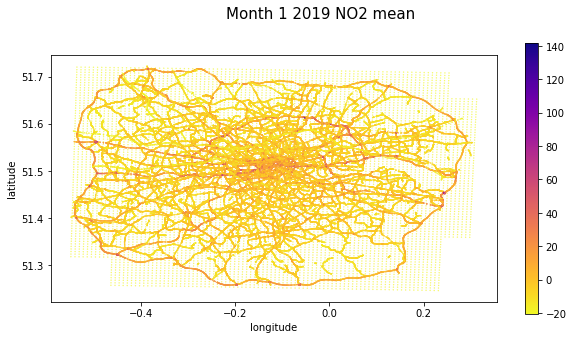

In [91]:
plot_in_grid_box(new_gdf, "2019_month_mean_NO2", f"Month {month_i} 2019 NO2 mean")